# Titanic classification model competition

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In this competition, I will try to build, train and deploy a classification model to predicts wheter a passanger survivied or not, given a data set with some features and chacteristics about the passangers.

## Importing data

In [2]:
df_raw_train = pd.read_csv('https://raw.githubusercontent.com/gabrielramos731/Data-science-projects/main/Titanic%20-%20Machine%20Learning%20from%20Disaster/data/train.csv')
df_raw_test = pd.read_csv('https://raw.githubusercontent.com/gabrielramos731/Data-science-projects/main/Titanic%20-%20Machine%20Learning%20from%20Disaster/data/test.csv')

In [3]:
df_train = df_raw_train.copy()
df_test = df_raw_test.copy()
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data info

After importing our data, let's take a look at the general info about our data and some descritive statistics.

In [169]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [170]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


As we can see, some columns has an expressive number of NaN values. 

In [171]:
df_train.duplicated().sum()

0

There is no duplicated row in our dataset

## Cleaning the null values

Let's analyze the null values and take the better decision about what to do with these values.

In [172]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- The 'Embarked' columns has just two NaN values, so we will complete they with his mode.
- To clean the NaN values of 'Age', we'll complete these values with an adequate groupby operation.

In [173]:
# complete the two values of 'Embarked' mode
print(df_train['Embarked'].value_counts())
print(df_test['Embarked'].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64
S    270
C    102
Q     46
Name: Embarked, dtype: int64


In [174]:
df_train.loc[df_train['Embarked'].isna(), ['Embarked']] = 'S'
df_test.loc[df_train['Embarked'].isna(), ['Embarked']] = 'S'

The NaN values from 'Age' column will be completed with the mean of 'Age', grouped by 'Sex', 'Pclass' and 'Embarked' variables.

In [175]:
# Complete NaN values from 'Age'
df_train['Age'] = df_train.groupby(['Sex','Pclass','Embarked'])['Age'].transform(lambda x: x.mean())
df_test['Age'] = df_train.groupby(['Sex','Pclass','Embarked'])['Age'].transform(lambda x: x.mean())
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

## Transforming the data

I'll not use the 'Name', 'Ticket' and 'Cabin' columns in models because they may not have importance in the predictions

The 'Sex' variable we can simply use the map due to there are just two values with no hierarch

The 'Embarked' variable we'll use dummies variables to not cause bias in our model.

In [176]:
df_train = df_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df_train['Sex'] = df_train['Sex'].map({'male':1, 'female':0})
df_train = pd.get_dummies(df_train, prefix='Embarked', prefix_sep='_')

# Applying the same transformations on the test data

df_test = df_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df_test['Sex'] = df_test['Sex'].map({'male':1, 'female':0})
df_test = pd.get_dummies(df_test, prefix='Embarked', prefix_sep='_')

## Correlationships

<AxesSubplot:>

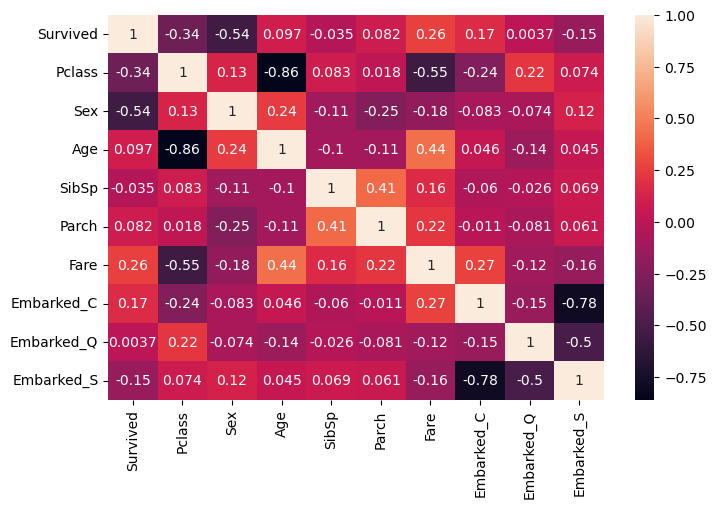

In [177]:
plt.figure(figsize=(8,5))
sns.heatmap(df_train.corr(), annot=True)

---

# Prediction models
In this section I'm gonna build and test some classification models.

To select the best model to predict the test data, I'll try some features, resources and classifiers to reach the best model.

## Feature selection
adsasda

In [178]:
X = df_train.iloc[:, 1:]
y = df_train['Survived']

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

acc_values = dict()

cv = KFold(n_splits=10, shuffle=True, random_state=42)

for quant_var in range(1, 9):
    tree_classifier = DecisionTreeClassifier(max_depth=3)

    # Cria um objeto Sequential Feature Selector para selecionar as duas melhores características
    sfs = SequentialFeatureSelector(tree_classifier, n_features_to_select=quant_var)

    # Aplica o Sequential Feature Selector ao conjunto de dados de treino
    X_train_sfs = sfs.fit_transform(X_train, y_train)

    # Obtém o índice das características selecionadas após o último ajuste
    selected_features_idx = sfs.get_support(indices=True)

    # Obtém os nomes das características selecionadas
    selected_features_names = X.columns[selected_features_idx]

    # Imprime as características selecionadas
    print("Características selecionadas: ", selected_features_names)

    values = cross_val_score(tree_classifier,
                           df_train[selected_features_names],
                           df_train['Survived'],
                           cv=cv, scoring='accuracy')
    acc_values[str(selected_features_names)] = values.mean()
    print("Acurácia média: ", values.mean())

Características selecionadas:  Index(['Sex'], dtype='object')
Acurácia média:  0.7867290886392009
Características selecionadas:  Index(['Sex', 'Age'], dtype='object')
Acurácia média:  0.8114232209737828
Características selecionadas:  Index(['Pclass', 'Sex', 'Age'], dtype='object')
Acurácia média:  0.8114232209737828
Características selecionadas:  Index(['Pclass', 'Sex', 'Age', 'Embarked_C'], dtype='object')
Acurácia média:  0.8114232209737828
Características selecionadas:  Index(['Pclass', 'Sex', 'Age', 'Embarked_C', 'Embarked_Q'], dtype='object')
Acurácia média:  0.8114232209737828
Características selecionadas:  Index(['Pclass', 'Sex', 'Age', 'Embarked_C', 'Embarked_Q', 'Embarked_S'], dtype='object')
Acurácia média:  0.8114232209737828
Características selecionadas:  Index(['Pclass', 'Sex', 'Age', 'Parch', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')
Acurácia média:  0.8102996254681647
Características selecionadas:  Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Pa

In [180]:
for c, v in acc_values.items():
    if (max(acc_values.values()) == v):
        print(c)
        print(v)
        break

Index(['Sex', 'Age'], dtype='object')
0.8114232209737828


In [181]:
best_features = ['Sex', 'Age']

## KNN

In [182]:
import warnings
warnings.filterwarnings("ignore")

knn = KNeighborsClassifier(n_neighbors=5)

cv = KFold(n_splits=10, shuffle=True, random_state=42)

values_knn = cross_val_score(knn, X[best_features], y, cv=cv, scoring='accuracy')
values_knn.mean()

0.7923470661672909

## Decision Tree

In [183]:
tree = DecisionTreeClassifier(max_depth=3)

values_tree = cross_val_score(tree, X[best_features], y, cv=cv, scoring='accuracy')
values_tree.mean()

0.8114232209737828

## Naive Bayes

In [184]:
nb = GaussianNB()

values_nb = cross_val_score(nb, X[best_features], y, cv=cv, scoring='accuracy')
values_nb.mean()

0.785605493133583

# Predictions

In [185]:
df_test.isna().sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          1
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [186]:
df_test[best_features]

,Sex,Age
0,1,26.574766
1,0,36.052632
2,1,23.223684
3,1,33.456522
4,0,26.574766
...,...,...
413,1,30.875889
414,0,26.574766
415,1,23.223684
416,1,29.719697


In [187]:
df_sub = pd.DataFrame({'PassengerId': range(892, 892+418)})

tree_classifier = DecisionTreeClassifier(max_depth=3)

tree_classifier.fit(X[best_features], y)

df_sub['Survived'] = tree_classifier.predict(df_test[best_features])

In [188]:
df_sub.to_csv('submission.csv', index=False)

In [189]:
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [190]:
def find_best_model(X_train, X_test, y_train, y_test):
    # Logistic Regression
    logreg = LogisticRegression(max_iter = 600, random_state = 42)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    logreg_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # Decision Tree
    decision_tree = DecisionTreeClassifier(random_state = 42)
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    decision_tree_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # Random Forest
    random_forest = RandomForestClassifier(random_state = 42)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)
    random_forest_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # XGBoost
    xgb = XGBClassifier(random_state = 42)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    xgb_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # GBM
    gbm = GradientBoostingClassifier(random_state = 42)
    gbm.fit(X_train, y_train)
    y_pred = gbm.predict(X_test)
    gbm_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # LightGBM
    lgbm = LGBMClassifier(random_state = 42)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    lgbm_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
        
    # Catboost
    catb = CatBoostClassifier(verbose = 0, random_state = 42)
    catb.fit(X_train, y_train)
    y_pred = catb.predict(X_test)
    catb_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # Histogram-based Gradient Boosting Classification Tree
    hgb = HistGradientBoostingClassifier(random_state = 42)
    hgb.fit(X_train, y_train)
    y_pred = hgb.predict(X_test)
    hgb_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    model_df = pd.DataFrame({'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'GBM', 'LightGBM', 'Catboost', 'HistBoost'],
                       'Score': [logreg_acc, decision_tree_acc, random_forest_acc, xgb_acc, gbm_acc, lgbm_acc, catb_acc, hgb_acc]})
    print(model_df.sort_values('Score', ascending = False).reset_index(drop = True))

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
find_best_model(X_train, X_test, y_train, y_test)

                 Model  Score
0             Catboost  82.12
1              XGBoost  81.01
2        Decision Tree  80.45
3                  GBM  80.45
4        Random Forest  79.89
5             LightGBM  79.33
6            HistBoost  79.33
7  Logistic Regression  78.21


In [7]:
df_train['Survived'].value_counts()/len(df_train)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [14]:
df_train_test, df_test_test = train_test_split(df_train, test_size=.2, random_state=42, stratify=df_train['Survived'])

In [16]:
df_train_test['Survived'].value_counts()/len(df_train_test)

0    0.616573
1    0.383427
Name: Survived, dtype: float64